### 3.4.1 IMDB数据集
它包含来自互联网电影数据库（IMDB）的 50,000条严重两极分化的评论。数据集被分为用于训练的25,000条评论与用于测试的25,000条评论，训练集和测试集都包含50%的正面评论和50%的负面评论。 

该数据已经进行预处理，评论已经被转换成了整数序列，其中每个整数代表字典中的某个单词。

我们需要关注的是模型在新数据上的性能。

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# num_words 仅保留训练数据中前10,000最常出现的单词。

17465344/17464789 [==============================] - 1s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

In [ ]:
train_data[0] # 代表一条由单词索引组成的评论
train_data # 代表评论组成的列表

In [10]:
train_labels[0] # 是否为正面或负面评论
train_labels #代表由0/1组陈的列表

1

### Decoding reviews back to text
将评论转化成文本

In [11]:
word_index = imdb.get_word_index() # word_index是一个将单词映射为整数索引的字典

reverse_word_index = dict( # 字典功能 
    [(value, key) for (key, value) in word_index.items()]) # 键值颠倒，将整数索引映射为单词

decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]) # 对train_data[0]中的各个i, 利用reverse_word_index进行映射
# 减去3是因为 0对应 padding; 2对应 start of sequence; 3对应 unknown. 它们通通被映射为?

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
reverse_word_index

In [ ]:
word_index

In [18]:
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[i]])

In [19]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 3.4.2 Preparing the data
准备数据  
你不能将整数序列直接输入神经网络。你需要将列表转换为张量。转换方法有以下两种。

1. 填充列表，使其具有相同的长度，再将列表转换成形状为(samples,  word_indices)的整数张量，然后网络第一层使用能处理这种整数张量的层（即  Embedding层，本书后面会详细介绍）。  

2. 对列表进行  one-hot编码，将其转换为  0和  1组成的向量。举个例子，序列[3,  5]将会被转换为 10  000维向量，只有索引为  3和  5的元素是   1，其余元素都是 0。然后网络第一层可以用Dense层，它能够处理浮点数向量数据。  

这里，我们采用后一种方法将数据向量化。


In [35]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000): # 取10,000是因为我们之前限定了10,000个最常见的单词，因此单词索引不会超过10,000
    # 以train_data[0]为例子
    results = np.zeros((len(sequences), dimension)) #产生一个 218* 10,000的矩阵
    for i, sequence in enumerate(sequences): #enumerate() 会产生[(0, 1),(1, 14),...,(217, 32)], 
                                             #前一个数字代表position, 后一个数字代表单词索引
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
for i in enumerate(train_data[0]):
    print(i)
train_data[0]

In [37]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [38]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### 3.4.3 Building your model
构建网络
输入数据是向量，而标签是标量（1和0），这是你会遇到的最简单的情况。有一类网络在这种问题上表现很好，就是带有relu激活的全连接层（Dense）的简单堆叠，比如Dense(16, activation=’relu’)。参数（16）是该层隐藏单元的个数。  

一个隐藏单元（hidden unit）是该层表示空间的一个维度。每个带有relu激活的Dense层都实现了下列张量运算：  
output = relu(dot(W, input) + b)  

16个隐藏单元对应的权重矩阵W的形状为(input_dimension,16)，与W做点积相当于将输入数据投影到16维表示空间中（然后再加上偏置向量 b并应用relu运算）。  

你可以将表示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。隐藏单元越多（即更高维的表示空间），网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导致学到不好的模式（这种模式会提高训练数据上的性能，但不会提高测试数据上的性能。  

我们所要确定的是两个关键结构:  
1) 网络到底有多少层  
2) 每层有多少个隐藏单元  

relu (rectified linear unit) 整流线型单元函数是将所有负值归零, 而sigmoid 函数将任意值压缩至[0,1]区间内。



In [ ]:
# 在此，我们构建两个中间层，每层都有16个隐藏单元；  
# 第三层输出一个标量，预测当前评论的情感。

In [44]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) # hidden unit=16
model.add(layers.Dense(16, activation='relu')) #hidden unit=16
model.add(layers.Dense(1, activation='sigmoid')) # hidden unit=1

### 什么是激活函数，为什么要使用激活函数？

如果没有relu等激活函数（也叫非线性），Dense层将只包含两个线性运算——点积和加法：
output = dot(W, input) + b (vs output = relu(dot(W, input) + b))  

这样Dense层就只能学习输入数据的线性变换（仿射变换）：该层的假设空间是从输入数据到 16位空间所有可能的线性变换集合。这种假设空间非常有限，无法利用多个表示层的优势，因为多个线性层堆叠实现的仍是线性运算，添加层数并不会扩展假设空间。

为了得到更丰富的假设空间，从而充分利用多层表示的优势，你需要添加非线性或激活函数。relu是深度学习中最常用的激活函数，但还有许多其他函数可选，它们都有类似的奇怪名称，比如prelu、elu等。

### 选择损失函数和优化器
二分类问题--binary crossentropy

In [45]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
# 配置优化器
# 1. 通过向optimizer参数传入一个优化器类实例来实现
model.compile(optimizer=optimizers.RMSprop(lr=0.001), # 定义lr
        loss='binary_crossentropy',
        metrics=['accuracy'])

# 2. 通过向loss和metrics参数传入函数对象来实现
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
        loss=losses.binary_crossentropy,
        metrics=[metrics.binary_accuracy])

### 3.4.4 Validating your approach
验证你的方法  

在原始训练数据留出10,000个样本作为验证集

In [47]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [48]:
#训练
model.compile(optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['acc'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, # 模型训练20轮次
                    batch_size=512, #batch_size 批量大小，即一次训练所选取的样本数，512个样本促成的小批量
                    validation_data=(x_val, y_val)) #将验证数据传入validation_data 来监控损失和精度

Epoch 1/20
30/30 [==============================] - 2s 55ms/step - loss: 0.5821 - acc: 0.7138 - val_loss: 0.3573 - val_acc: 0.8726
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2954 - acc: 0.9060 - val_loss: 0.3038 - val_acc: 0.8828
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2048 - acc: 0.9330 - val_loss: 0.2809 - val_acc: 0.8890
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1620 - acc: 0.9520 - val_loss: 0.2785 - val_acc: 0.8906
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1245 - acc: 0.9630 - val_loss: 0.3064 - val_acc: 0.8782
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1155 - acc: 0.9654 - val_loss: 0.3019 - val_acc: 0.8874
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0828 - acc: 0.9784 - val_loss: 0.3223 - val_acc: 0.8816
Epoch 8/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0694 - a

In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

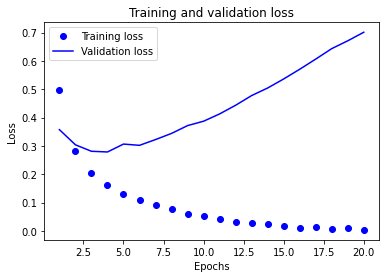

In [51]:
# 画图 Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"] # 提取在取出10,000个样品外的train集上的loss values
val_loss_values = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values
epochs = range(1, len(loss_values) + 1) # x axis
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


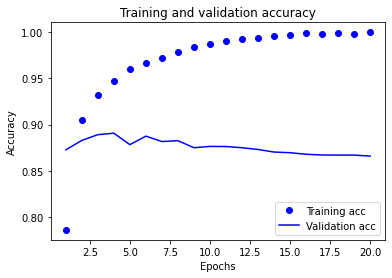

In [56]:
# 画图 Plotting the training and validation accuracy
plt.clf()
acc = history_dict["acc"]
val_acc = history_dict["val_acc"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

如你所见，训练损失每轮都在降低，训练精度每轮都在提升。这就是梯度下降优化的预期结果——你想要最小化的量随着每次迭代越来越小。但验证损失和验证精度并非如此：它们似乎在第四轮达到最佳值。这就是我们之前警告过的一种情况：模型在训练数据上的表现越来越好，但在前所未见的数据上不一定表现得越来越好。准确地说，你看到的是过拟合（overfit）：在第二轮之后，你对训练数据过度优化，最终学到的表示仅针对于训练数据，无法泛化到训练集之外的数据。

在这种情况下，为了防止过拟合，你可以在  3轮之后停止训练。通常来说，你可以使用许多方法来降低过拟合，我们将在第 4章中详细介绍。

In [59]:
#### 从头训练一个模型 Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 10ms/step - loss: 0.5699 - accuracy: 0.7318
Epoch 2/4
49/49 [==============================] - 1s 10ms/step - loss: 0.2919 - accuracy: 0.9033
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.2078 - accuracy: 0.9277
Epoch 4/4
782/782 [==============================] - 1s 736us/step - loss: 0.3128 - accuracy: 0.8761


In [60]:
results #平均值

[0.312835693359375, 0.8761199712753296]

In [61]:
#Using a trained model to generate predictions on new data
model.predict(x_test)
#网络对某些样本的结果非常确信（大于等于 0.99，或小于等于 0.01），但对其他结果却不那么确信（0.6或  0.4）。

array([[0.1676541 ],
       [0.99964523],
       [0.6325836 ],
       ...,
       [0.07757184],
       [0.04434693],
       [0.42856777]], dtype=float32)

### Further experiments 进一步的实验
前面使用了两个隐藏层。你可以尝试使用一个或三个隐藏层，然后观察对验证精度和测试精度的影响。  
尝试使用更多或更少的隐藏单元，比如  32个、64个等。  
尝试使用mse损失函数代替binary_crossentropy。  
尝试使用tanh激活（这种激活在神经网络早期非常流行）代替relu。

In [64]:
model = models.Sequential()
model.add(layers.Dense(32, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
        loss='mean_squared_error',
        metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 10ms/step - loss: 0.1727 - accuracy: 0.7502
Epoch 2/4
49/49 [==============================] - 1s 11ms/step - loss: 0.0758 - accuracy: 0.9141
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.0556 - accuracy: 0.9359
Epoch 4/4
782/782 [==============================] - 1s 746us/step - loss: 0.0888 - accuracy: 0.8799


In [65]:
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
        loss='mean_squared_error',
        metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 10ms/step - loss: 0.1697 - accuracy: 0.7428
Epoch 2/4
49/49 [==============================] - 0s 10ms/step - loss: 0.0675 - accuracy: 0.9101
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.0497 - accuracy: 0.9362
Epoch 4/4
782/782 [==============================] - 1s 775us/step - loss: 0.1063 - accuracy: 0.8638


In [66]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
        loss='mean_squared_error',
        metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 3s 14ms/step - loss: 0.1828 - accuracy: 0.7188
Epoch 2/4
49/49 [==============================] - 1s 14ms/step - loss: 0.0713 - accuracy: 0.9069
Epoch 3/4
49/49 [==============================] - 1s 14ms/step - loss: 0.0496 - accuracy: 0.9361
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0974 - accuracy: 0.8734


### 下面是你应该从这个例子中学到的要点。

通常需要对原始数据进行大量预处理，以便将其转换为张量输入到神经网络中。单词序列可以编码为二进制向量，但也有其他编码方式。  
带有relu激活的Dense层堆叠，可以解决很多种问题（包括情感分类），你可能会经常用到这种模型。  
对于二分类问题（两个输出类别），网络的最后一层应该是只有一个单元并使用sigmoid激活的Dense层，网络输出应该是0~1范围内的标量，表示概率值。  
对于二分类问题的  sigmoid标量输出，你应该使用binary_crossentropy损失函数。  
无论你的问题是什么，rmsprop优化器通常都是足够好的选择。这一点你无须担心。  
随着神经网络在训练数据上的表现越来越好，模型最终会过拟合，并在前所未见的数据上得到越来越差的结果。一定要一直监控模型在训练集之外的数据上的性能。